In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease, mean_loss_decrease

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
print(sns.__version__)

0.11.0


In [3]:
df = pd.read_csv('https://dqlab-dataset.s3-ap-southeast-1.amazonaws.com/dqlab_telco_final.csv')
df.head()

,UpdatedAt,customerID,gender,SeniorCitizen,Partner,tenure,PhoneService,StreamingTV,InternetService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn
0,202006,45759018157,Female,No,Yes,1,No,No,Yes,Yes,29.85,29.85,No
1,202006,45315483266,Male,No,Yes,60,Yes,No,No,Yes,20.50,1198.80,No
2,202006,45236961615,Male,No,No,5,Yes,Yes,Yes,No,104.10,541.90,Yes
3,202006,45929827382,Female,No,Yes,72,Yes,Yes,Yes,Yes,115.50,8312.75,No
4,202006,45305082233,Female,No,Yes,56,Yes,Yes,Yes,No,81.25,4620.40,No



    UpdatedAt        = Periode of Data taken
    customerID       = Customer ID
    gender           = Whether the customer is a male or a female (Male, Female)
    SeniorCitizen    = Whether the customer is a senior citizen or not (Yes, No)
    Partner          = Whether the customer has a partner or not (Yes, No)
    tenure           = Number of months the customer has stayed with the company
    PhoneService     = Whether the customer has a phone service or not (Yes, No)
    InternetService  =  Customer’s internet service provider (Yes, No)
    StreamingTV      = Whether the customer has streaming TV or not (Yes, No)
    PaperlessBilling = Whether the customer has paperless billing or not (Yes, No)
    MonthlyCharges   = The amount charged to the customer monthly
    TotalCharges     = The total amount charged to the customer
    Churn            = Whether the customer churned or not (Yes, No)


In [4]:
print("Total rows           : ", df.shape[0])
print("Total cols           : ", df.shape[1])
print("Total missing values : ", df.isnull().sum().sum())

Total rows           :  6950
Total cols           :  13
Total missing values :  0


# Cek Target

C:\Users\WIN10\miniconda3\envs\jcopml\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


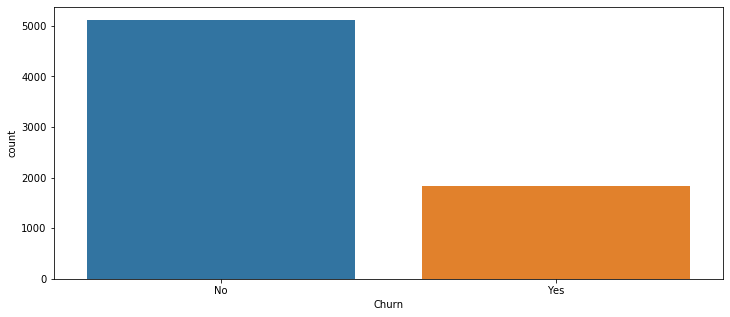

In [5]:
plt.figure(figsize=(12,5))
sns.countplot(df.Churn)
plt.show()

## Cek Duplikasi

In [6]:
df.sort_values(by="UpdatedAt").drop_duplicates(["customerID"])
print("Total rows           : ", df.shape[0])
print("Total cols           : ", df.shape[1])
print("Total missing values : ", df.isnull().sum().sum())

Total rows           :  6950
Total cols           :  13
Total missing values :  0


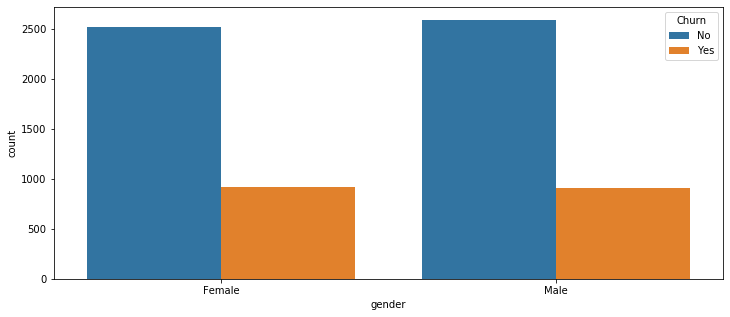

In [7]:
plt.figure(figsize=(12,5))
sns.countplot(x="gender", hue="Churn", data=df)
plt.show()

In [8]:
df_backup = df.copy(deep=True)
df.drop(columns=["UpdatedAt","customerID"], inplace=True)
df.head()

,gender,SeniorCitizen,Partner,tenure,PhoneService,StreamingTV,InternetService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,1,No,No,Yes,Yes,29.85,29.85,No
1,Male,No,Yes,60,Yes,No,No,Yes,20.50,1198.80,No
2,Male,No,No,5,Yes,Yes,Yes,No,104.10,541.90,Yes
3,Female,No,Yes,72,Yes,Yes,Yes,Yes,115.50,8312.75,No
4,Female,No,Yes,56,Yes,Yes,Yes,No,81.25,4620.40,No


In [9]:
df.Churn = df.Churn.map({"No":0, "Yes":1})
df.head()

,gender,SeniorCitizen,Partner,tenure,PhoneService,StreamingTV,InternetService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,1,No,No,Yes,Yes,29.85,29.85,0
1,Male,No,Yes,60,Yes,No,No,Yes,20.50,1198.80,0
2,Male,No,No,5,Yes,Yes,Yes,No,104.10,541.90,1
3,Female,No,Yes,72,Yes,Yes,Yes,Yes,115.50,8312.75,0
4,Female,No,Yes,56,Yes,Yes,Yes,No,81.25,4620.40,0


In [10]:
num_feature = ["tenure","MonthlyCharges","TotalCharges"]
cat_feature = df.drop(columns=num_feature).columns.to_list()[0:-1]
print("num_feature : ", num_feature)
print("cat_feature : ", cat_feature)

num_feature :  ['tenure', 'MonthlyCharges', 'TotalCharges']
cat_feature :  ['gender', 'SeniorCitizen', 'Partner', 'PhoneService', 'StreamingTV', 'InternetService', 'PaperlessBilling']


In [11]:
from jcopml.plot import plot_association_matrix, plot_correlation_matrix, plot_correlation_ratio

In [12]:
plot_correlation_matrix(df, "Churn", numeric_col=num_feature)

interactive(children=(ToggleButtons(description='method', options=('spearman', 'kendall', 'pearson', 'pearson_…

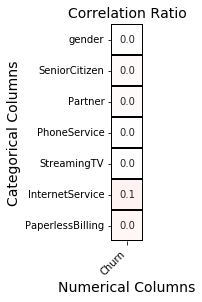

In [13]:
plot_correlation_ratio(df, catvar=cat_feature, numvar=["Churn"])

#####  Jika Dilihat dari correlasi tidak ada yang berkorelasi kuat 

In [14]:
X = df.drop(columns="Churn")
y = df.Churn

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5560, 10), (1390, 10), (5560,), (1390,))

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

In [16]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), num_feature),
    ('categoric', cat_pipe(encoder='onehot'), cat_feature),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
])


model = GridSearchCV(pipeline, gsp.logreg_params, cv=5, scoring='f1', n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.0s


{'algo__C': 0.001, 'algo__fit_intercept': False}
0.5614973262032086 0.5606812105262745 0.5531295487627366


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    5.2s finished


In [17]:
from jcopml.plot import plot_classification_report, plot_confusion_matrix, plot_roc_curve, plot_pr_curve

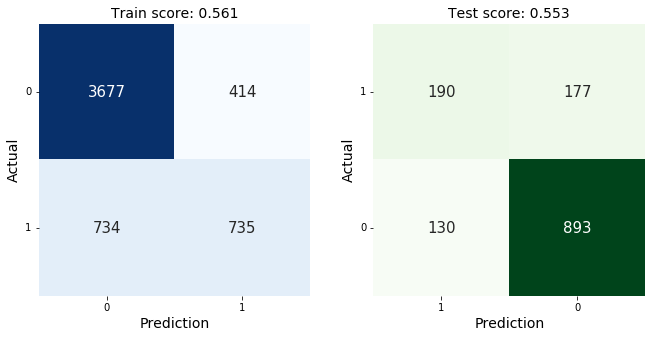

In [18]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

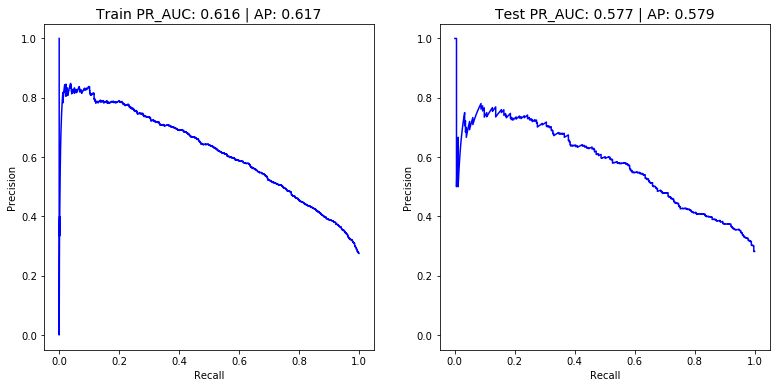

In [19]:
plot_pr_curve(X_train, y_train, X_test, y_test, model)

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [21]:
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.rf_params, cv=3, scoring="f1", n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   33.8s finished


{'algo__max_depth': 43, 'algo__max_features': 0.4210779940242304, 'algo__min_samples_leaf': 13, 'algo__n_estimators': 140}
0.63046875 0.5564329705760241 0.5402985074626866


In [22]:
plot_classification_report(X_train, y_train, X_test, y_test, model, report=True)

Train report
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      4091
           1       0.74      0.55      0.63      1469

    accuracy                           0.83      5560
   macro avg       0.80      0.74      0.76      5560
weighted avg       0.82      0.83      0.82      5560


Test report
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1023
           1       0.60      0.49      0.54       367

    accuracy                           0.78      1390
   macro avg       0.71      0.69      0.70      1390
weighted avg       0.77      0.78      0.77      1390



In [23]:
df.head()

,gender,SeniorCitizen,Partner,tenure,PhoneService,StreamingTV,InternetService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,1,No,No,Yes,Yes,29.85,29.85,0
1,Male,No,Yes,60,Yes,No,No,Yes,20.50,1198.80,0
2,Male,No,No,5,Yes,Yes,Yes,No,104.10,541.90,1
3,Female,No,Yes,72,Yes,Yes,Yes,Yes,115.50,8312.75,0
4,Female,No,Yes,56,Yes,Yes,Yes,No,81.25,4620.40,0


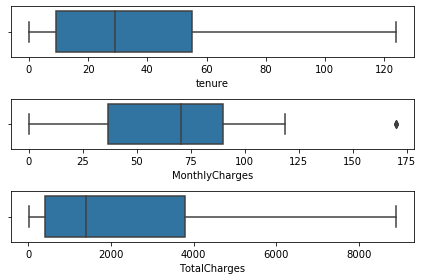

In [24]:
fig, ax = plt.subplots(3,1)

for num_lbl in range(len(num_feature)):
    ax[num_lbl].set_xlabel(num_feature[num_lbl])
    sns.boxplot(x=num_feature[num_lbl], hue="Churn", data=df, ax=ax[num_lbl])
plt.tight_layout()
plt.show()

In [25]:
df.MonthlyCharges.quantile(q=(3/4))

89.85

In [26]:
df.MonthlyCharges[df.MonthlyCharges < 89.85]

0       29.85
1       20.50
4       81.25
5       85.25
6       80.00
        ...  
6942    39.20
6944    82.65
6945    44.75
6946    70.15
6947    85.55
Name: MonthlyCharges, Length: 5202, dtype: float64

In [27]:
df.MonthlyCharges.max()

169.93125

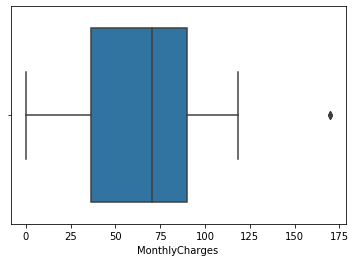

In [28]:
sns.boxplot(x=df.MonthlyCharges[df.MonthlyCharges < 170], hue="Churn", data=df)

In [29]:
df.MonthlyCharges[df.MonthlyCharges > 165]

424     169.93125
1056    169.93125
6261    169.93125
Name: MonthlyCharges, dtype: float64

In [30]:
df_backup[df.MonthlyCharges > 165]

,UpdatedAt,customerID,gender,SeniorCitizen,Partner,tenure,PhoneService,StreamingTV,InternetService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn
424,202006,45756943547,Female,No,Yes,72,Yes,Yes,Yes,Yes,169.93125,8889.13125,No
1056,202006,45598913663,Female,No,Yes,68,Yes,Yes,Yes,No,169.93125,7990.05000,No
6261,202006,45898486532,Female,No,No,71,Yes,Yes,Yes,Yes,169.93125,8477.60000,No


### Hapus Outlier

In [31]:
df = df[(df.MonthlyCharges < 165)]
df.head()

,gender,SeniorCitizen,Partner,tenure,PhoneService,StreamingTV,InternetService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,1,No,No,Yes,Yes,29.85,29.85,0
1,Male,No,Yes,60,Yes,No,No,Yes,20.50,1198.80,0
2,Male,No,No,5,Yes,Yes,Yes,No,104.10,541.90,1
3,Female,No,Yes,72,Yes,Yes,Yes,Yes,115.50,8312.75,0
4,Female,No,Yes,56,Yes,Yes,Yes,No,81.25,4620.40,0


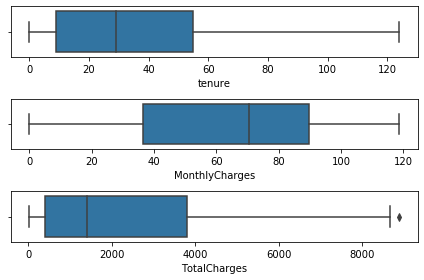

In [32]:
fig, ax = plt.subplots(3,1)

for num_lbl in range(len(num_feature)):
    ax[num_lbl].set_xlabel(num_feature[num_lbl])
    sns.boxplot(x=num_feature[num_lbl], hue="Churn", data=df, ax=ax[num_lbl])
plt.tight_layout()
plt.show()

In [33]:
df.TotalCharges.max()

8889.13125

In [34]:
df.TotalCharges.quantile(q=(3/4))

3793.05

In [35]:
df = df[df.TotalCharges < 8500]
df.head()

,gender,SeniorCitizen,Partner,tenure,PhoneService,StreamingTV,InternetService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,1,No,No,Yes,Yes,29.85,29.85,0
1,Male,No,Yes,60,Yes,No,No,Yes,20.50,1198.80,0
2,Male,No,No,5,Yes,Yes,Yes,No,104.10,541.90,1
3,Female,No,Yes,72,Yes,Yes,Yes,Yes,115.50,8312.75,0
4,Female,No,Yes,56,Yes,Yes,Yes,No,81.25,4620.40,0


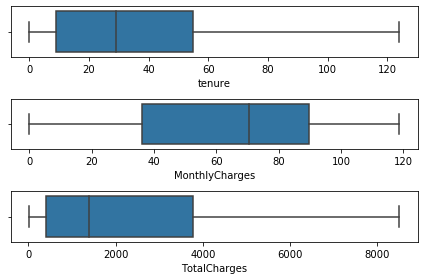

In [36]:
fig, ax = plt.subplots(3,1)

for num_lbl in range(len(num_feature)):
    ax[num_lbl].set_xlabel(num_feature[num_lbl])
    sns.boxplot(x=num_feature[num_lbl], hue="Churn", data=df, ax=ax[num_lbl])
plt.tight_layout()
plt.show()

In [37]:
X = df.drop(columns="Churn")
y = df.Churn

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5552, 10), (1388, 10), (5552,), (1388,))

In [38]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), num_feature),
    ('categoric', cat_pipe(encoder='onehot'), cat_feature),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42, ))
])


model = GridSearchCV(pipeline, gsp.logreg_params, cv=5, scoring='f1', n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s


{'algo__C': 10.0, 'algo__fit_intercept': False}
0.5470817120622569 0.5491518396332037 0.5807407407407408


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    2.5s finished


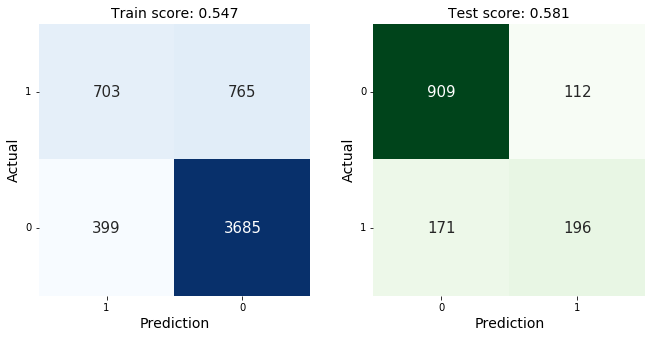

In [39]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

In [40]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(transform='yeo-johnson', scaling="standard"), num_feature),
    ('categoric', cat_pipe(encoder='onehot', ), cat_feature),
])
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.rf_params, cv=3, scoring="f1", n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

C:\Users\WIN10\miniconda3\envs\jcopml\lib\site-packages\jcopml\pipeline\_pipeline.py:65: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   36.3s finished


{'algo__max_depth': 30, 'algo__max_features': 0.5133240027692805, 'algo__min_samples_leaf': 4, 'algo__n_estimators': 123}
0.7535563244905804 0.5462559079456025 0.5570370370370369


In [41]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(transform='yeo-johnson', scaling="robust"), num_feature),
    ('categoric', cat_pipe(encoder='ordinal' ), cat_feature),
])
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.rf_params, cv=3, scoring="f1", n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

C:\Users\WIN10\miniconda3\envs\jcopml\lib\site-packages\jcopml\pipeline\_pipeline.py:65: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   33.3s finished


{'algo__max_depth': 46, 'algo__max_features': 0.4756699028339012, 'algo__min_samples_leaf': 5, 'algo__n_estimators': 196}
0.7115085536547434 0.5447686163965234 0.5675675675675677


In [42]:
X_train

,gender,SeniorCitizen,Partner,tenure,PhoneService,StreamingTV,InternetService,PaperlessBilling,MonthlyCharges,TotalCharges
1232,Male,No,No,7,Yes,Yes,Yes,Yes,94.25,669.00
3809,Male,No,Yes,0,Yes,No,No,No,25.75,1400.85
1315,Female,Yes,No,32,Yes,Yes,Yes,No,90.95,2897.95
4585,Male,No,No,1,Yes,No,No,No,20.20,20.20
3378,Female,No,No,22,No,Yes,Yes,Yes,50.35,1098.85
...,...,...,...,...,...,...,...,...,...,...
1804,Female,No,No,1,Yes,No,Yes,Yes,69.50,69.50
5299,Female,No,Yes,69,Yes,Yes,Yes,Yes,116.00,8182.85
5388,Male,No,No,9,Yes,No,No,No,20.40,181.80
3733,Male,Yes,No,10,Yes,No,Yes,Yes,72.85,688.65


In [43]:
cat_feature

['gender',
 'SeniorCitizen',
 'Partner',
 'PhoneService',
 'StreamingTV',
 'InternetService',
 'PaperlessBilling']

In [44]:
# Note: You could not use gsp, rsp, and bsp recommendation in advance mode
# You should specify your own parameter grid / interval when tuning
preprocessor = ColumnTransformer([
    ('numeric1', num_pipe(), num_feature),
    ('categoric1', cat_pipe(encoder='ordinal'), cat_feature[1:]),
    ('categoric2', cat_pipe(encoder='onehot'), ["gender"])    
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.rf_params, cv=3, scoring="f1", n_iter=100, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.2min finished


{'algo__max_depth': 30, 'algo__max_features': 0.5133240027692805, 'algo__min_samples_leaf': 4, 'algo__n_estimators': 123}
0.7558631295655517 0.5455380223367919 0.5752608047690014


In [45]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(transform='yeo-johnson', scaling="robust"), num_feature),
    ('categoric1', cat_pipe(encoder='ordinal'), cat_feature[1:]),
    ('categoric2', cat_pipe(encoder='onehot'), ["gender"])    
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42, ))
])

model = RandomizedSearchCV(pipeline, rsp.logreg_params, cv=3, scoring='f1', n_iter=100, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))


Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\WIN10\miniconda3\envs\jcopml\lib\site-packages\jcopml\pipeline\_pipeline.py:65: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.6s


{'algo__C': 1.0377055497115135, 'algo__fit_intercept': False}
0.5453818472610955 0.5428204541043744 0.5819295558958651


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   10.5s finished


In [46]:
from xgboost import XGBClassifier

In [47]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), num_feature),
    ('categoric1', cat_pipe(encoder='ordinal'), cat_feature[1:]),
    ('categoric2', cat_pipe(encoder='onehot'), ["gender"])    
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBClassifier(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, scoring='f1', n_iter=100, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   27.6s finished


{'algo__colsample_bytree': 0.4764187326615571, 'algo__gamma': 8, 'algo__learning_rate': 0.5666605409239297, 'algo__max_depth': 5, 'algo__n_estimators': 132, 'algo__reg_alpha': 1.2894637422275765, 'algo__reg_lambda': 0.08346037418037723, 'algo__subsample': 0.7926430253327523}
0.5826771653543308 0.5583960866313981 0.5952380952380952


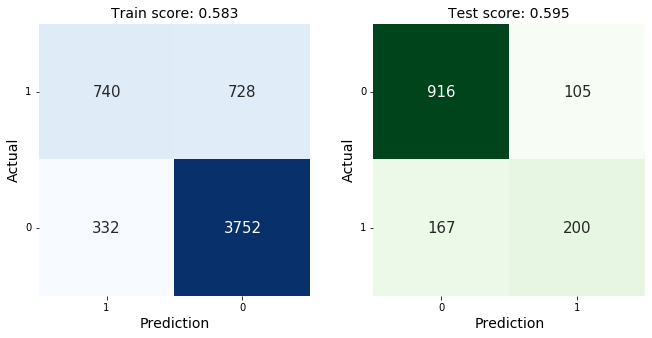

In [49]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

### EDA

In [50]:
cat_feature

['gender',
 'SeniorCitizen',
 'Partner',
 'PhoneService',
 'StreamingTV',
 'InternetService',
 'PaperlessBilling']

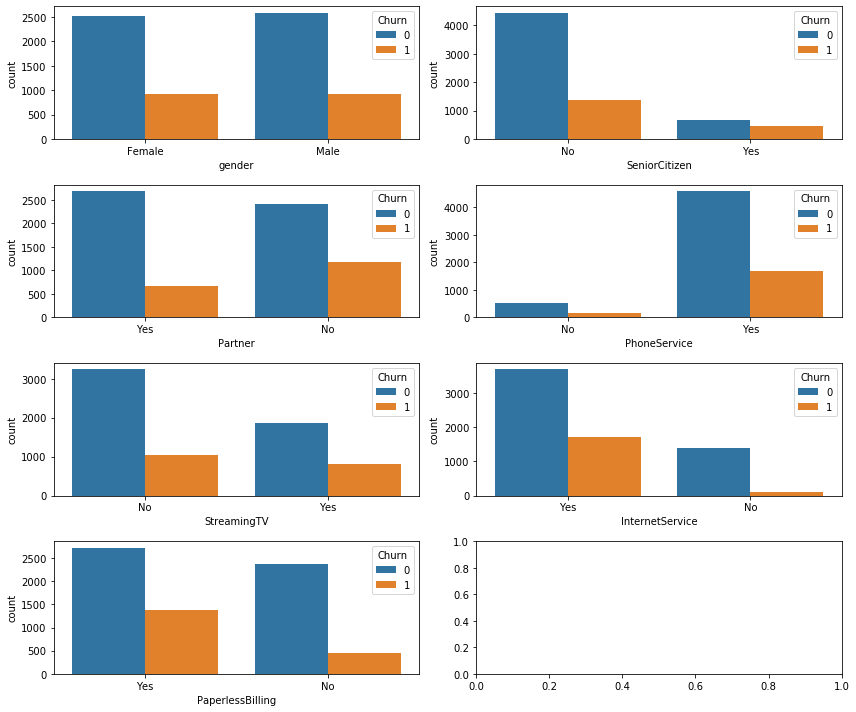

In [51]:
fig, ax = plt.subplots(4,2)
fig.set_size_inches(12,10)
rows=0
cols=0
for idx in range(8):
    try:
        sns.countplot(x=cat_feature[idx], hue="Churn", data=df, ax=ax[rows][cols])
        cols+=1
    except Exception as e:
        pass
    if cols>1:
        rows+=1
        cols=0

plt.tight_layout()
plt.show()

C:\Users\WIN10\miniconda3\envs\jcopml\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


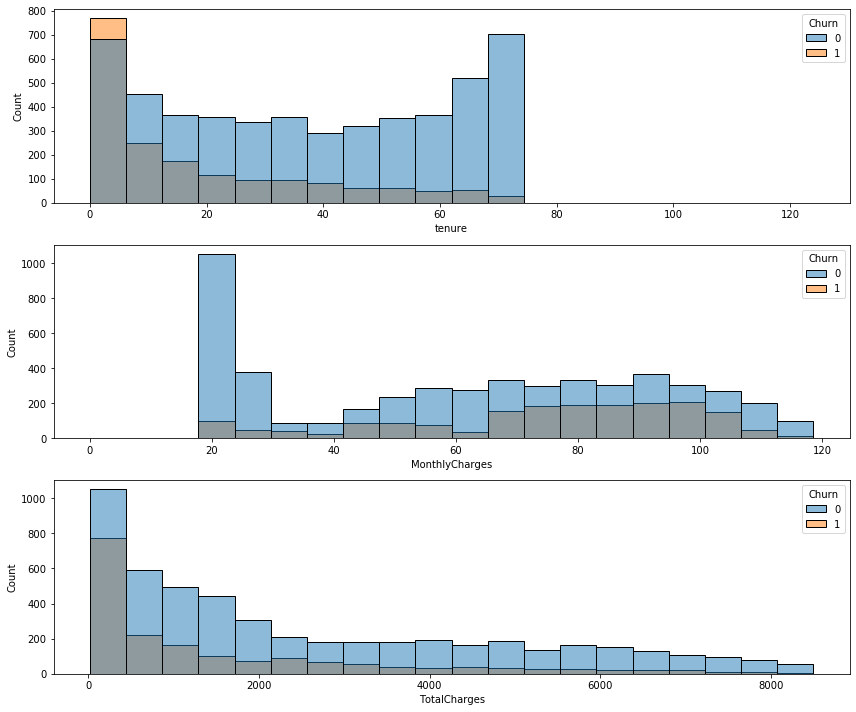

In [52]:
fig, ax = plt.subplots(3)
fig.set_size_inches(12,10)
rows=0
for num in num_feature:
    sns.histplot(data=df, x=num, hue="Churn", ax=ax[rows], bins=20, )
    rows+=1
fig.tight_layout()
fig.show()
fig.savefig("fig.png")